In [1]:
# 1. 📦 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as T
from kaggleisic.isic_class import ISIC_HDF5_Dataset

# Plotting style
sns.set(style="whitegrid")
%matplotlib inline

In [2]:
# 2. 📂 Load Metadata
# File paths
TRAIN_METADATA_CSV = "../data/new-train-metadata.csv"
TEST_METADATA_CSV = "../data/students-test-metadata.csv"
TRAIN_HDF5 = "../data/train-image.hdf5"
TEST_HDF5 = "../data/test-image.hdf5"

# Load CSV metadata
train_df = pd.read_csv(TRAIN_METADATA_CSV)
test_df = pd.read_csv(TEST_METADATA_CSV)

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
display(train_df.head())

/var/folders/g9/kxkk4qgj7b51026tpb72p1x40000gn/T/ipykernel_53032/377873113.py:9: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(TRAIN_METADATA_CSV)


Train shape: (400959, 55)
Test shape: (100, 44)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.00000,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,Right Leg - Upper,Right Leg,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.00000,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,Head & Neck,Head & Neck,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,Memorial Sloan Kettering Cancer Center,CC-BY,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,62.909730,53.961180,61.670520,3.265153,24.184620,0.00000,5.447655,4.485044,-7.709336,9.092376,6.290359,0.932147,Torso Back Top Third,Torso Back,1.194905,2.959177e-04,4.798335,0.000000,8.886309,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,56.414429,60.060388,18.649518,23.314841,6.079940,14.889242,0.51452,2.077572,0.326788,-4.665323,4.783413,6.400196,0.654458,Torso Front Top Half,Torso Front,2.481328,2.198945e+01,1.975874,1.771705,9.514499,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,ACEMID MIA,CC-0,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,46.946070,52.041180,46.276310,54.855740,2.101708,19.902560,0.00000,4.668053,0.754434,-8.579431,9.148495,6.531302,0.946448,Torso Front Top Half,Torso Front,0.929916,1.378832e-03,3.658854,0.000000,6.467562,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


/var/folders/g9/kxkk4qgj7b51026tpb72p1x40000gn/T/ipykernel_53032/843708896.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values,


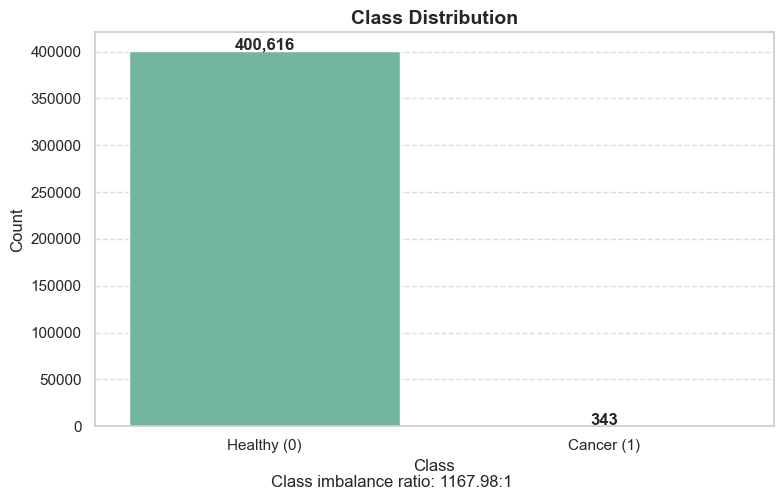

Class Distribution:
Class 0: 400,616 samples (99.91%)
Class 1: 343 samples (0.09%)


In [3]:
# 3. 📊 Class Distribution (Cancer vs. Healthy)
# Define target column
target_column = 'target'

# Plot class distribution
plt.figure(figsize=(8, 5))
class_counts = train_df[target_column].value_counts().sort_index()
sns.barplot(x=class_counts.index, y=class_counts.values,
            palette=['#66c2a5', '#fc8d62'])

# Add count labels on top of bars
for i, count in enumerate(class_counts.values):
    plt.text(i, count + 1500, f"{count:,}", ha='center', fontweight='bold')

# Set labels with class meaning
plt.xticks([0, 1], ['Healthy (0)', 'Cancer (1)'])
plt.title("Class Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add information about data balance
ratio = class_counts.values[0] / \
    class_counts.values[1] if len(class_counts) > 1 else "N/A"
plt.figtext(0.5, 0.01, f"Class imbalance ratio: {ratio:.2f}:1", ha='center')

plt.tight_layout()
plt.show()

# Print detailed class statistics
print("Class Distribution:")
class_dist = train_df[target_column].value_counts()
class_percentages = 100 * train_df[target_column].value_counts(normalize=True)
for i in range(len(class_dist)):
    print(
        f"Class {i}: {class_dist.iloc[i]:,} samples ({class_percentages.iloc[i]:.2f}%)")

🧩 Columns with missing values:


iddx_5                 400958
mel_mitotic_index      400916
mel_thick_mm           400908
iddx_4                 400440
iddx_3                 399944
iddx_2                 399941
lesion_id              378954
sex                     11513
anatom_site_general      5756
age_approx               2796
dtype: int64

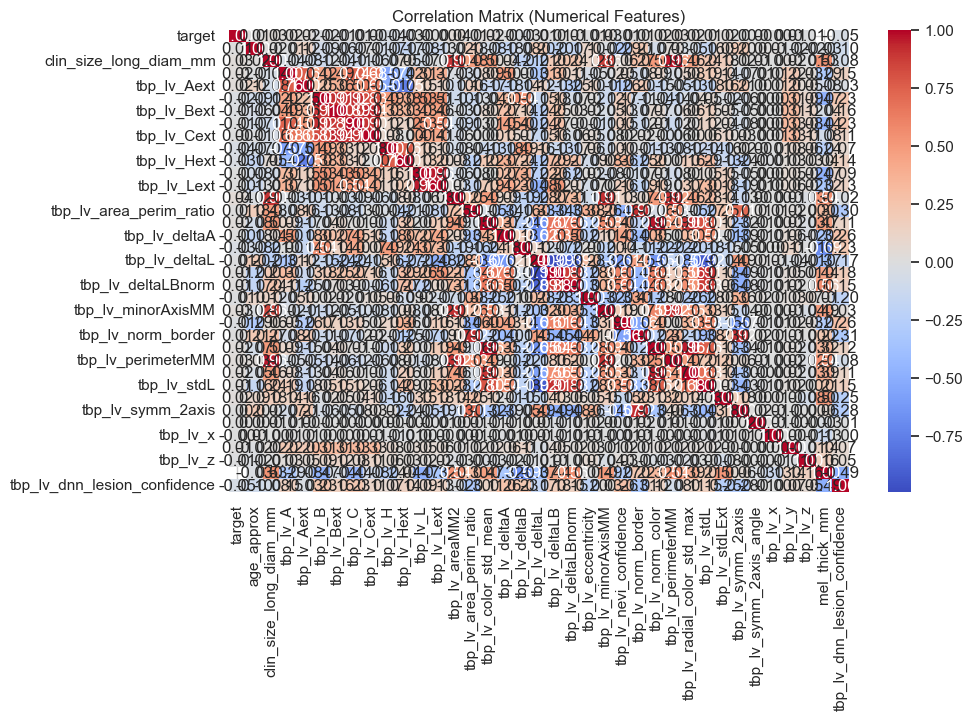

In [4]:
# 4. 🔎 Metadata Missingness & Correlation
# Missing values
missing = train_df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
print("🧩 Columns with missing values:")
display(missing)

# Correlation heatmap (numerical only)
numerical_cols = train_df.select_dtypes(include=np.number)
if not numerical_cols.empty:
    plt.figure(figsize=(10, 6))
    sns.heatmap(numerical_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix (Numerical Features)")
    plt.show()
else:
    print("ℹ️ No numerical columns found for correlation.")

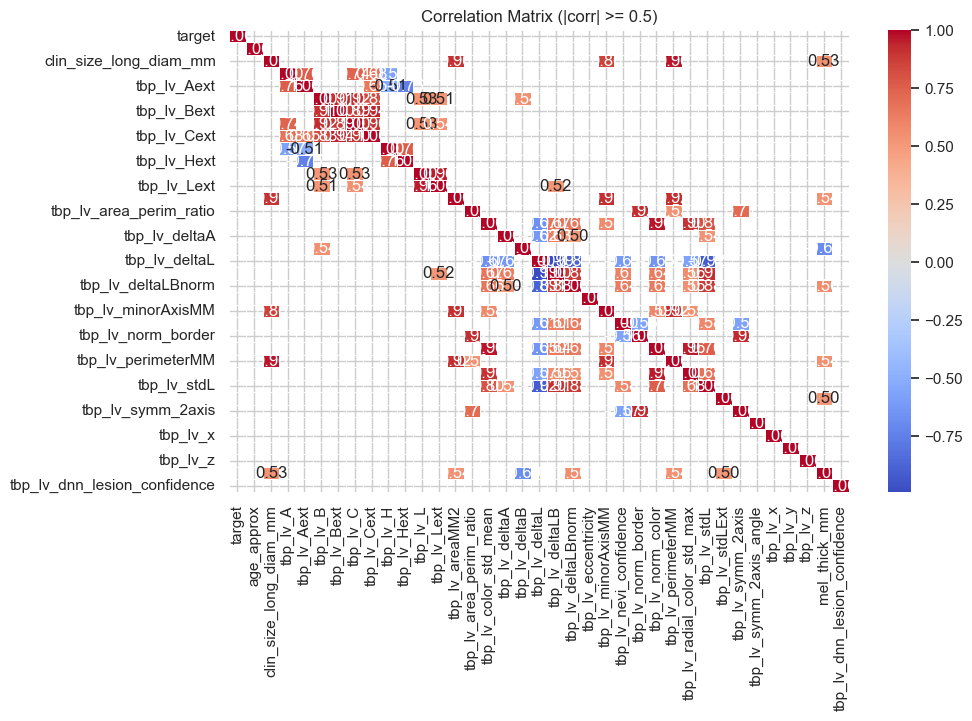

In [5]:
def plot_reduced_correlation_matrix(df, correlation_threshold=0.5):
    # Get numerical columns for correlation analysis
    numerical_cols = df.select_dtypes(include=np.number)

    if not numerical_cols.empty:
        # Calculate the correlation matrix
        corr_matrix = numerical_cols.corr()

        # Mask to keep only correlations above the threshold
        mask = np.abs(corr_matrix) >= correlation_threshold

        # Create a heatmap of the filtered correlation matrix
        plt.figure(figsize=(10, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
                    fmt='.2f', linewidths=0.5, mask=~mask)
        plt.title(f"Correlation Matrix (|corr| >= {correlation_threshold})")
        plt.show()
    else:
        print("ℹ️ No numerical columns found for correlation.")


# Plot reduced correlation matrix with a threshold of 0.5 (can be adjusted)
plot_reduced_correlation_matrix(train_df, correlation_threshold=0.5)

In [6]:
# Simple transform for viewing (no normalization or resizing)
view_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

# Create a small dataset just for EDA
eda_dataset = ISIC_HDF5_Dataset(
    df=train_df,  # just a few samples for visualization
    hdf5_path=TRAIN_HDF5,
    transform=view_transform,
    is_labelled=True
)

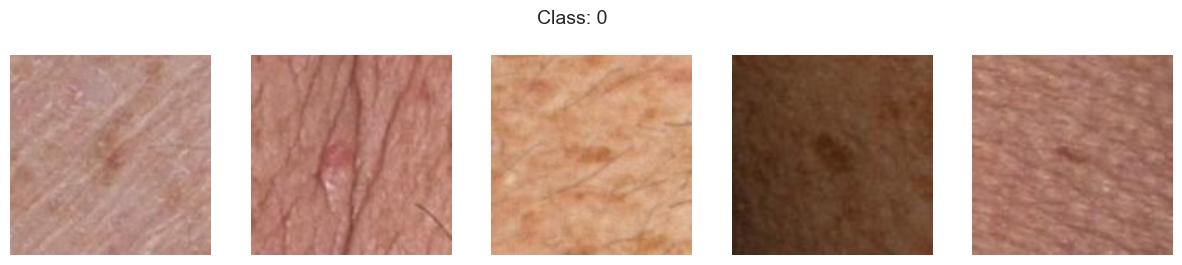

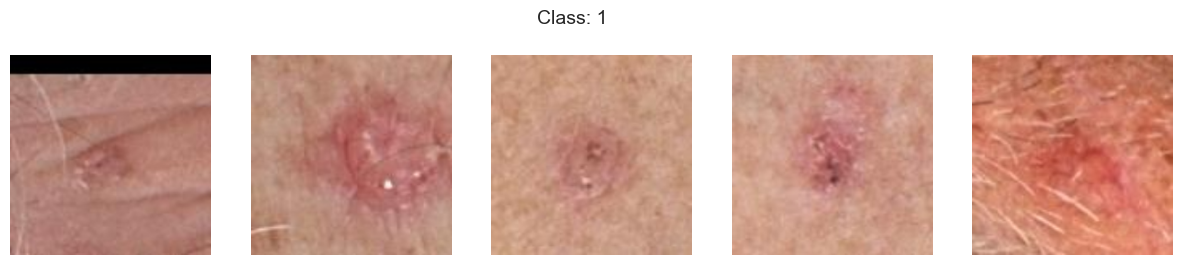

In [7]:
def show_samples_by_class(df, dataset, label_col='target', n=5):
    classes = df[label_col].unique()
    for cls in classes:
        subset_df = df[df[label_col] == cls].head(n)
        fig, axes = plt.subplots(1, len(subset_df), figsize=(15, 3))
        fig.suptitle(f"Class: {cls}", fontsize=14)

        for i, row in enumerate(subset_df.itertuples()):
            # Use the original index from the DataFrame `df`
            dataset_idx = row.Index  # This is the index in the original DataFrame

            # Get image from dataset
            image, _, _ = dataset[dataset_idx]
            # Convert from (C, H, W) to (H, W, C)
            image_np = image.permute(1, 2, 0).numpy()

            # Rescale image to [0, 1] range
            image_np = image_np.clip(0, 1)

            # Show image
            axes[i].imshow(image_np)
            axes[i].axis("off")

        plt.show()


# Show samples by class
show_samples_by_class(train_df, eda_dataset, label_col='target', n=5)